# What Model Best Predicts A Country's Happiness Score And What Are The Most Important Social And Economic Variables? 


The World Happiness Report is a publication that uses survey data to show how people across the world rate their happiness. 
An entry in the report is a country's average response to life evaluation questions for a given year between 2005 to 2020. Several social and economic variables are measured in these questions, such as the Freedom To Make Life Choices and Log GDP Per Capita. I was wondering which type of model performs the best at predicting a country's happiness? I also want to know which social and economic predictors are the most important? 

To answer these questions, I will test the Machine Learning Algorithms Linear Regression, Decision Tree, Random Forest, Gradient Boosting, and Bagging on the World Happiness Report Dataset to find the the model that predicts the data best and identify the most statistically significant variables. I will graph the models using Tableau. 

## 1. Cleaning The Data

First I will load in the Python libraries I need like Pandas and download the dataset off the World Happiness Report website https://worldhappiness.report/ed/2021/#appendices-and-data.

In [2]:
import os
import pandas as pd
import numpy as np 
import random
import matplotlib.pyplot as plt
import seaborn as sns 
import statsmodels.api as sm
import mlxtend

from sklearn import tree
from sklearn.tree import export_graphviz, DecisionTreeRegressor
from sklearn.feature_selection import SequentialFeatureSelector, RFE
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV #splits the data
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler, scale
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV 
from tabulate import tabulate

In [3]:
os.chdir(r"C:\Users\maazc\Desktop\Notes\Python\Data Project") 
#Navigate to the proper directory. The r is there before the " " to convert it to a raw string. \U is read as unicode
Happiness = pd.read_excel("DataPanelWHR2021C2.xls") #load in the data
happiness = Happiness.copy() #Our dataframe

Now I can clean the data starting with the variables.

In [4]:
list(happiness.columns.values)

['Country name',
 'year',
 'Life Ladder',
 'Log GDP per capita',
 'Social support',
 'Healthy life expectancy at birth',
 'Freedom to make life choices',
 'Generosity',
 'Perceptions of corruption',
 'Positive affect',
 'Negative affect']

Life Ladder or the Cantril Scale is a question where respondents are asked to rate their life on a scale from 0 through 10 where 0 is the worst possible life for them and 10 is the best possible life. This is the happiness score the models will try to predict. 

Positive Affect and Negative Affect are other metrics of happiness that will be dropped to make the analysis simpler. But they are worth looking into another time. 

Log GDP Per Capita, Social Support, Healthy Life Expectancy At Birth, Freedom To Make Life Choices, Generosity, and Perceptions Of Corruption are the social and economic factors that will predict happiness. 

In [5]:
happiness = happiness.drop(['Positive affect', 'Negative affect'], axis = 1) #remove Positive affect and Negative affect

I want to capitalize all the column names.

In [6]:
happiness.columns = map(str.title, happiness.columns) #Capitalize the first letter of each column name
columns = list(happiness.columns.values) #column names
columns

['Country Name',
 'Year',
 'Life Ladder',
 'Log Gdp Per Capita',
 'Social Support',
 'Healthy Life Expectancy At Birth',
 'Freedom To Make Life Choices',
 'Generosity',
 'Perceptions Of Corruption']

The column names are now capitalized. Next I need to check the column data types. 

In [7]:
happiness.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1949 entries, 0 to 1948
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country Name                      1949 non-null   object 
 1   Year                              1949 non-null   int64  
 2   Life Ladder                       1949 non-null   float64
 3   Log Gdp Per Capita                1913 non-null   float64
 4   Social Support                    1936 non-null   float64
 5   Healthy Life Expectancy At Birth  1894 non-null   float64
 6   Freedom To Make Life Choices      1917 non-null   float64
 7   Generosity                        1860 non-null   float64
 8   Perceptions Of Corruption         1839 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 137.2+ KB


Here we see that 7 columns use data type float64. If I want the models to run, I need to convert the column values to the data type float32. 

In [8]:
happiness.iloc[:, [2,3,4,5,6,7,8]] = happiness.iloc[:, [2,3,4,5,6,7,8]].astype(np.float32) 
happiness.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1949 entries, 0 to 1948
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country Name                      1949 non-null   object 
 1   Year                              1949 non-null   int64  
 2   Life Ladder                       1949 non-null   float32
 3   Log Gdp Per Capita                1913 non-null   float32
 4   Social Support                    1936 non-null   float32
 5   Healthy Life Expectancy At Birth  1894 non-null   float32
 6   Freedom To Make Life Choices      1917 non-null   float32
 7   Generosity                        1860 non-null   float32
 8   Perceptions Of Corruption         1839 non-null   float32
dtypes: float32(7), int64(1), object(1)
memory usage: 83.9+ KB


The models will also fail if there are missing values, so I will check for them. 

In [9]:
print(happiness.isnull().sum()) #Find all rows with missing values
print(happiness.isnull().sum().sum()) #Total number of missing values

Country Name                          0
Year                                  0
Life Ladder                           0
Log Gdp Per Capita                   36
Social Support                       13
Healthy Life Expectancy At Birth     55
Freedom To Make Life Choices         32
Generosity                           89
Perceptions Of Corruption           110
dtype: int64
335


All the predictors have 335 total missing values. Removing them would drastically change the models. Instead, I will replace those values with their respective column means instead.

In [10]:
predictors = columns[3:9] #columns with NA values

for col in happiness[predictors]:
    happiness[col] = happiness[col].fillna(happiness[col].mean()) 

print(happiness.isnull().sum()) #should be 0

Country Name                        0
Year                                0
Life Ladder                         0
Log Gdp Per Capita                  0
Social Support                      0
Healthy Life Expectancy At Birth    0
Freedom To Make Life Choices        0
Generosity                          0
Perceptions Of Corruption           0
dtype: int64


There are no more missing values. The last thing I need to do is write the data to a CSV file so I can graph it in Tableau. 

In [11]:
happiness.to_csv("happiness_cleaned.csv") 

## 2. Modeling

### 2a. Linear Regression

I need to extract my predictors and response variable from the dataframe. Then, I will split the dataset into a training set and a test set. I will also create a validation set and for all 3, compute the Mean Squared Error (MSE). The MSE measures the average squared difference between estimated values and actual values. I want to find the model that best minimizes it because it will best predict the happiness score.  

In [12]:
#Life Ladder is what we are predicting so it will be excluded. Country Name and Year are not factors so they will also be dropped. 
X = happiness.drop(['Life Ladder', 'Country Name', 'Year'], axis = 1) 
Y = happiness['Life Ladder']

#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = .25, random_state = 15) #25% of the data will be tested

lr = LinearRegression().fit(X_train, y_train)

print(f"Training MSE : {mse(y_train, lr.predict(X_train))}") 
print(f"Test MSE     : {mse(y_test, lr.predict(X_test))}")

lr = LinearRegression()
print(f"CV MSE       : {-1 * cross_val_score(lr, X, Y, scoring = 'neg_mean_squared_error').mean()}")

Training MSE : 0.3018629550933838
Test MSE     : 0.39065566658973694
CV MSE       : 0.34414794743061067


The Linear Model's Test mean squared error is .391 and its Cross-validation mean squared error is .344.  

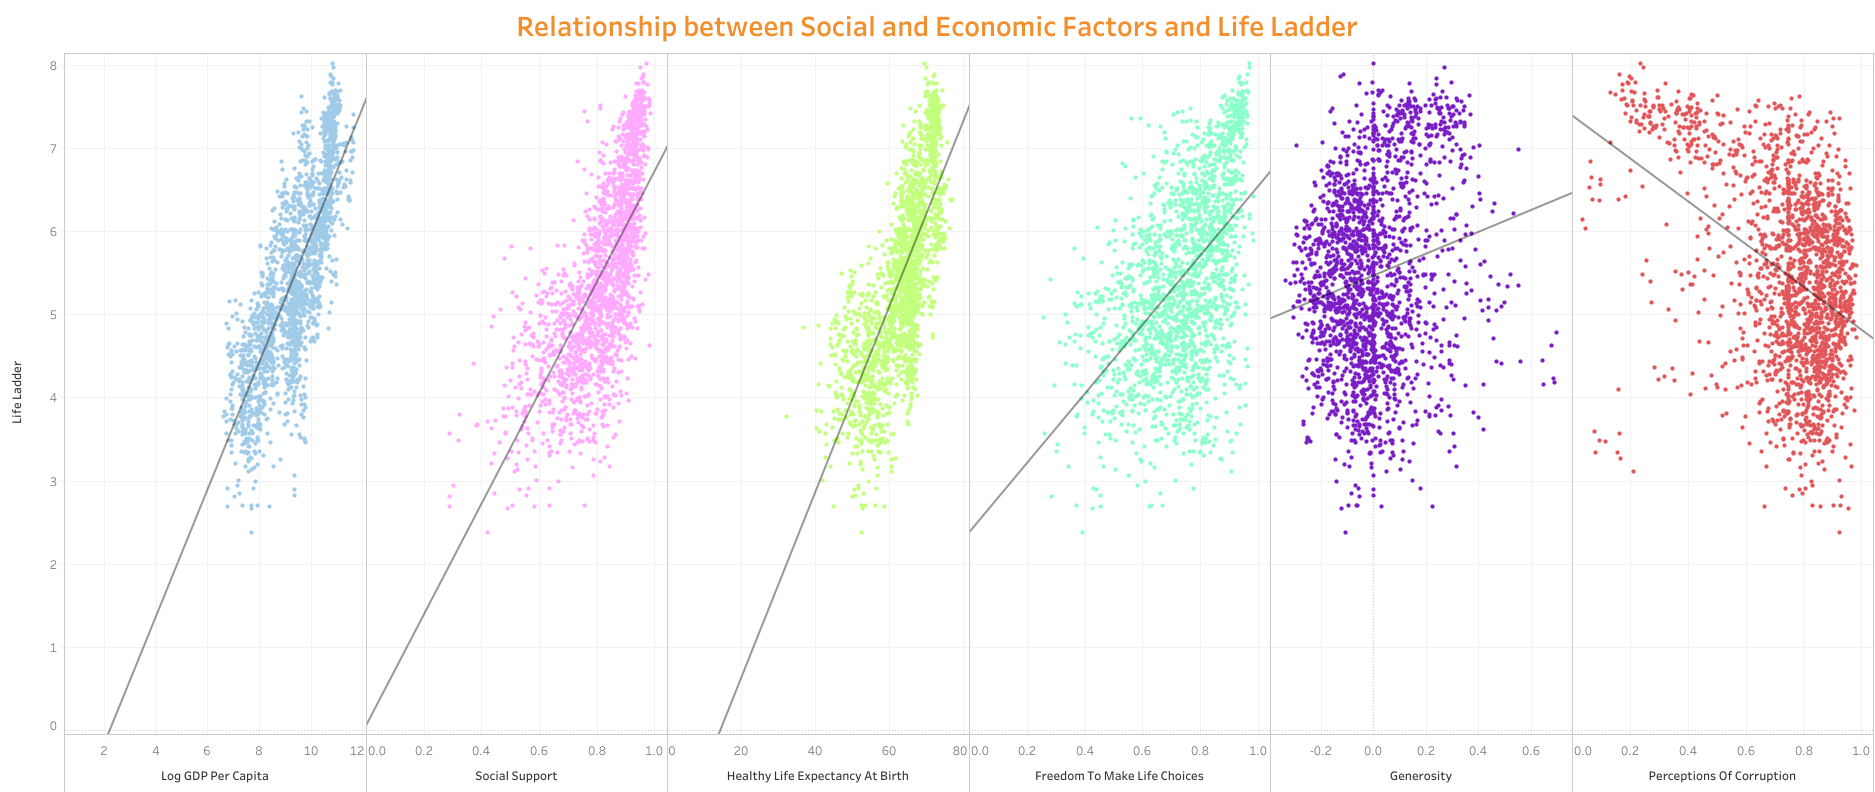

I used Tableau to graph the linear models. Some social and economic variables like Log GDP Per Capita have a linear relationship with happiness score, while others like Generosity clearly do not. 

### 2b. Decision Tree Model

The next model I will test is the Decision Tree Model. We will find the best split before testing the Model. 

In [13]:
tree_reg = DecisionTreeRegressor(random_state=1).fit(X_train, y_train)
tree_params = {'max_depth':np.linspace(1, 20, 20), 'max_features':np.linspace(0.1, 1, 10)}
tree_best = GridSearchCV(tree_reg, tree_params, cv=10, scoring = 'neg_mean_squared_error').fit(X_train, y_train)
tree_best.best_estimator_

DecisionTreeRegressor(max_depth=6.0, max_features=0.9, random_state=1)

The best split has a max depth of 6 and .9 max features. 

In [14]:
tree_reg = DecisionTreeRegressor(max_depth = 6, max_features = 0.9, random_state = 1).fit(X_train, y_train)

The methods of calculating the mean squared errors are the same for all the tree based methods so I will write a function to avoid repetition. I will use 5 fold Cross-validation for all of them. 

In [15]:
def tree_mse(model_reg): 
    print(f"Training MSE : {mse(y_train, model_reg.predict(X_train))}") 
    print(f"Test MSE     : {mse(y_test, model_reg.predict(X_test))}") 

    kf = KFold(n_splits=5, shuffle=True, random_state=35) #5 fold Cross-validation

    model_reg_scores = cross_val_score(estimator=model_reg, X=X, y=Y, cv=kf, scoring='neg_mean_squared_error')
    print(f"CV MSE       : {-np.mean(model_reg_scores)}")

In [16]:
tree_mse(tree_reg)

Training MSE : 0.19354378280424453
Test MSE     : 0.31653325082080946
CV MSE       : 0.31001827035029983


The Decision Tree Model's Test mean squared error is .317 and its Cross-validation mean squared error is .31.

Here is my Decision Tree.

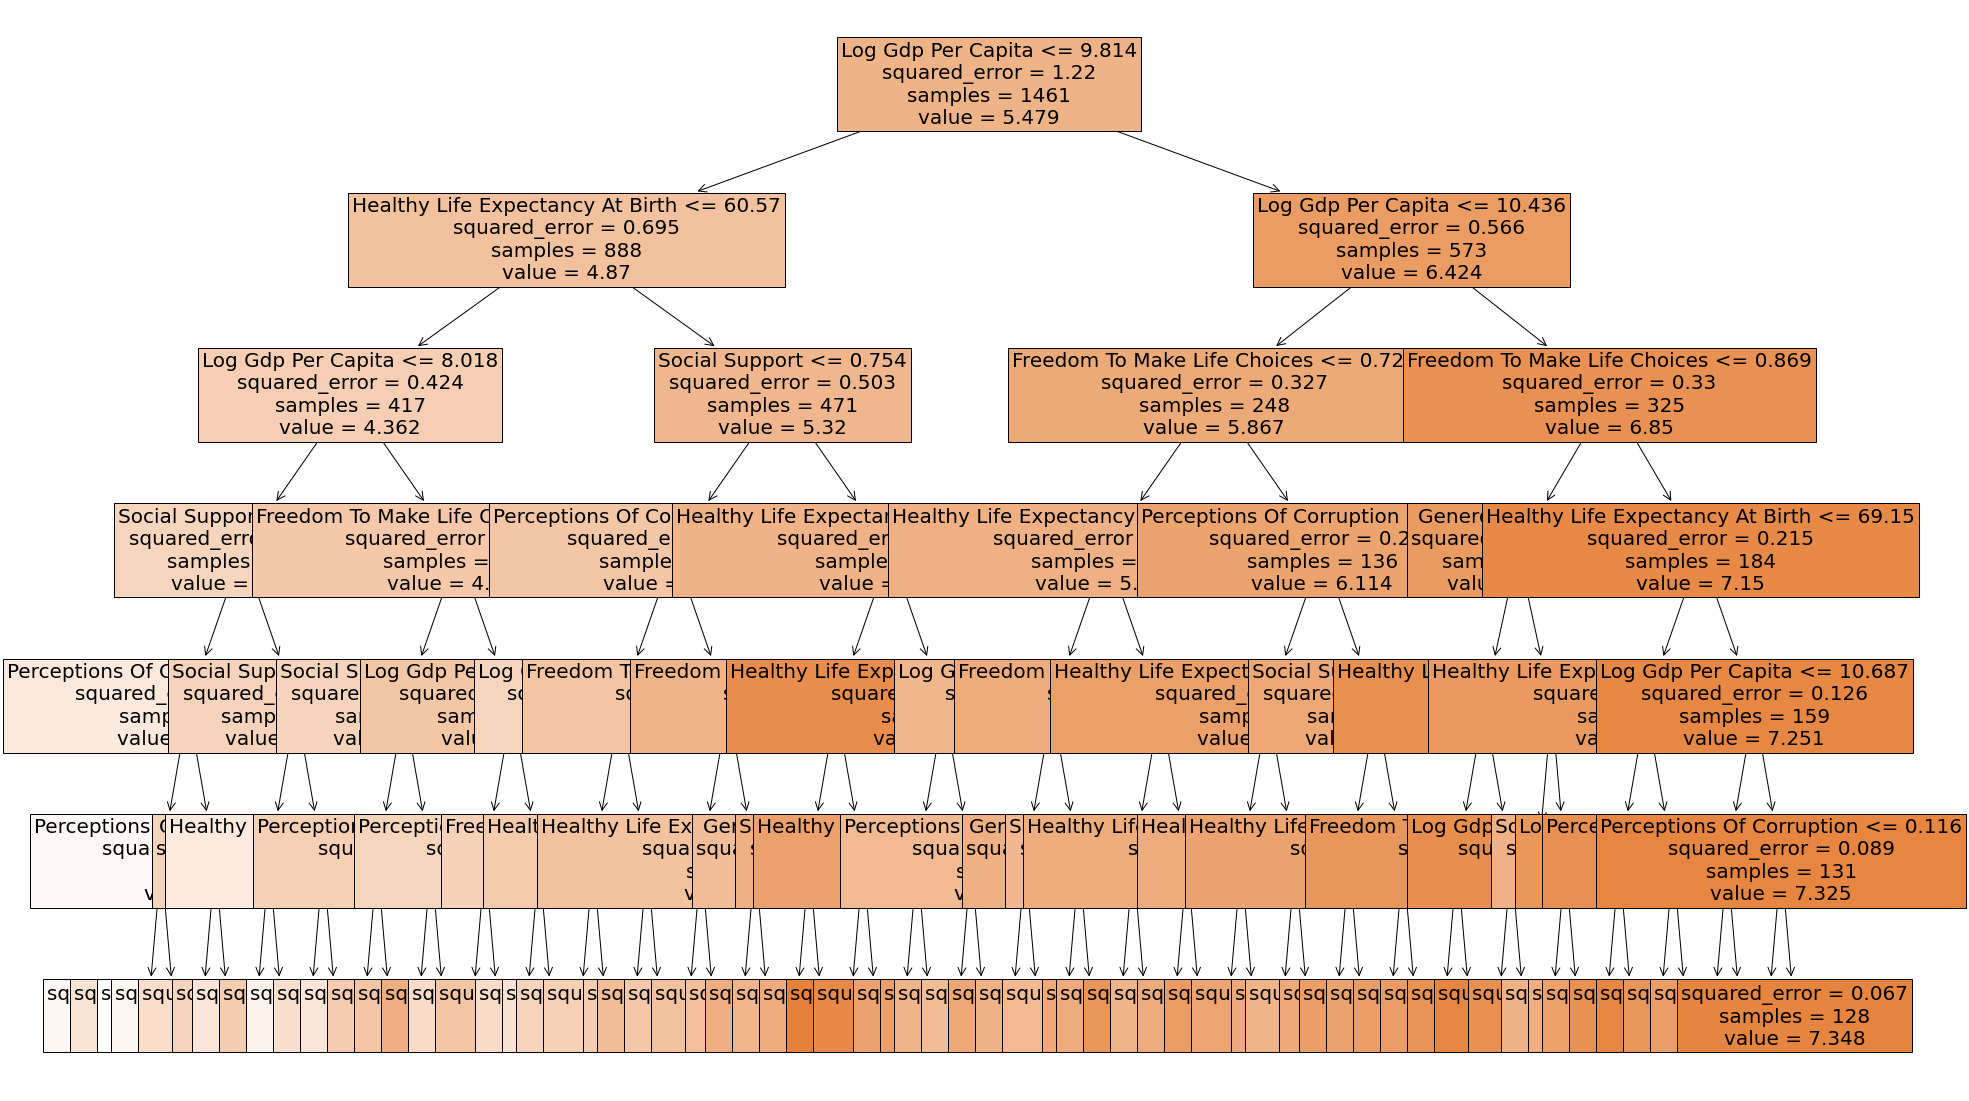

In [17]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (30,20))
tree.plot_tree(tree_reg, feature_names = predictors, filled = True, fontsize=20)
plt.savefig('tree.png', dpi=300)
plt.show()

To create a scatterplot of my model's predictions in Tableau, I need to create a CSV file. I want to use this same CSV file and update it every time I make predictions with a new model. I will write a function that does this by adding predictions to a dataframe and then updating the CSV. 

In [18]:
models = pd.DataFrame(data = dict({'Y-Test' : y_test})) #Use the dict() function to add the data

def add_predictions(name, values):
    models[name] = values
    models.to_csv("model_predictions.csv") #Create dataframe and then write it to CSV
    
add_predictions('Tree Predictions', tree_reg.predict(X_test))

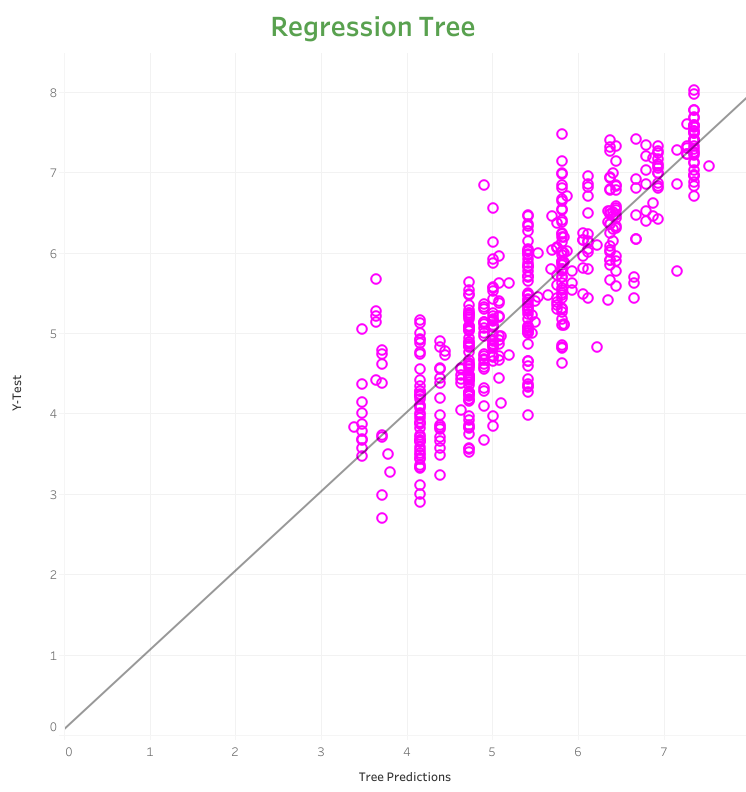

### 2c. Random Forest Model

I will test the Random Forest Model. 

In [19]:
rf_reg = RandomForestRegressor(bootstrap = True, random_state=1).fit(X_train, y_train.ravel())
rf_params = {'max_depth':np.linspace(1, 15, 6, dtype=int), 'max_features':np.linspace(0.1, 1, 4), 'n_estimators':np.linspace(100, 300, 5, dtype=int)}
rf_best = GridSearchCV(rf_reg, rf_params, cv=5, scoring = 'neg_mean_squared_error').fit(X_train, y_train)
rf_best.best_estimator_


RandomForestRegressor(max_depth=15, max_features=0.4, n_estimators=300,
                      random_state=1)

The best split has a max depth of 15, .4 max features, and 300 estimators.

In [20]:
rf_reg = RandomForestRegressor(max_features=0.4, max_depth=15, n_estimators=300,
                               random_state=1).fit(X_train, y_train.ravel())

tree_mse(rf_reg)

Training MSE : 0.029278576446950172
Test MSE     : 0.2292492712243863
CV MSE       : 0.1982281256002379


The Random Forest Model's Test mean squared error is .229 and its Cross-validation mean squared error is .198.

For the Random Forest, Gradient Boosting, and Bagging Models, we can graph the significance of our variables. I will write another function that allows me to convert the data to a CSV file so it can be graphed in Tableau. 

In [21]:
importance = pd.DataFrame(index = predictors) #No data except the row names of our predictors

def importance_models(name, model_reg):
    
    importance[name] = model_reg.feature_importances_*100 
    importance.to_csv("importance_models.csv") #write to CSV 
    print(importance) 
    
importance_models('Importance (RF)', rf_reg)


                                  Importance (RF)
Log Gdp Per Capita                      32.308781
Social Support                          20.007024
Healthy Life Expectancy At Birth        25.101109
Freedom To Make Life Choices            10.631933
Generosity                               4.744188
Perceptions Of Corruption                7.206964


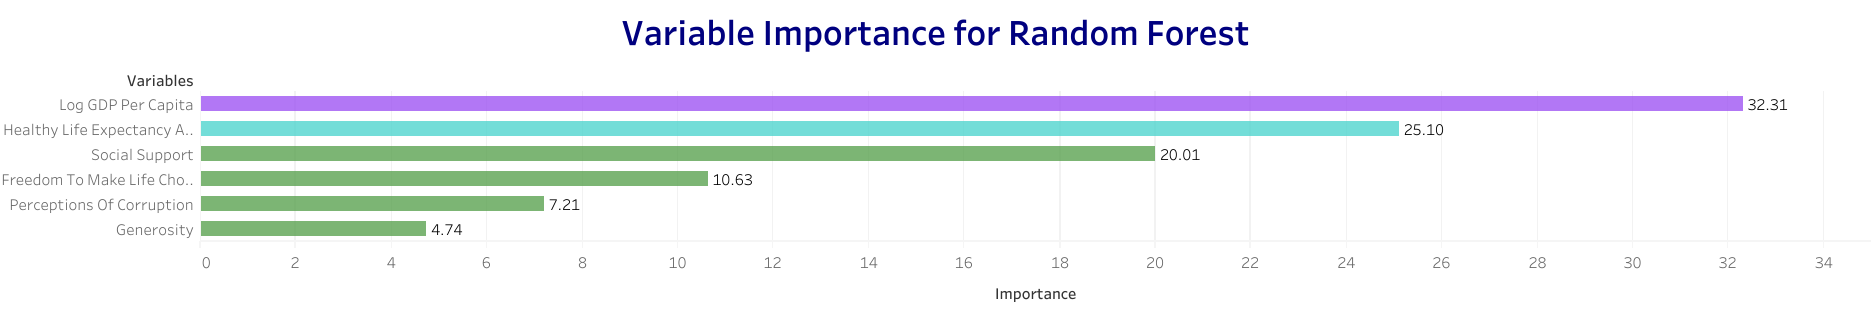

The order of importance is Log GDP Per Capita, Healthy Life Expectancy At Birth, Social Support, Freedom To Make Choices,  Perceptions Of Corruption, and Generosity. 

In [22]:
add_predictions('RF Predictions', rf_reg.predict(X_test))

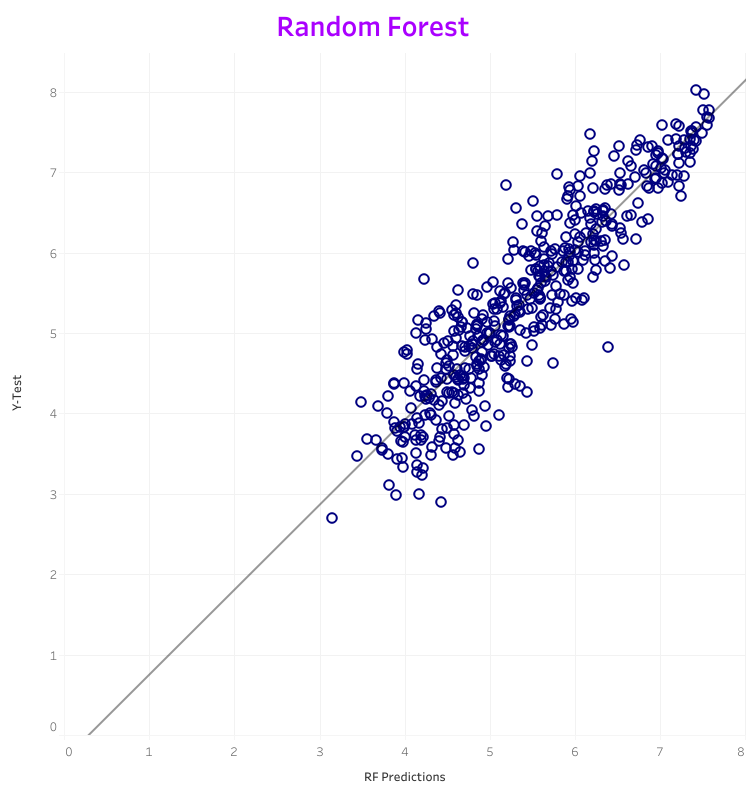

### 2d. Gradient Boosting Model

I will test the Gradient Boosting Model. 

In [23]:
boost_reg = GradientBoostingRegressor(random_state=1)
boost_params = {'learning_rate':np.linspace(0.001, 0.01, 5), 'n_estimators':np.linspace(100, 300, 5, dtype=int),
               'max_depth':np.linspace(1, 10, 10, dtype=int)}
boost_best = GridSearchCV(boost_reg, boost_params, cv=5, scoring = 'neg_mean_squared_error').fit(X_train, y_train)
boost_best.best_estimator_

GradientBoostingRegressor(learning_rate=0.01, max_depth=7, n_estimators=300,
                          random_state=1)

The best split has a max depth of 7, a learning rate of .01, and 300 estimators. 

In [24]:
boost_reg = GradientBoostingRegressor(n_estimators=300, learning_rate=0.01, max_depth = 7, random_state = 1)
boost_reg.fit(X_train, y_train.ravel())

tree_mse(boost_reg)

Training MSE : 0.04940261233926649
Test MSE     : 0.2390370344345335
CV MSE       : 0.22319604223455566


The Gradient Boosting Model's Test mean squared error is .239 and its Cross-validation mean squared error is .223.

In [25]:
importance_models('Importance (Boosting)', boost_reg)

                                  Importance (RF)  Importance (Boosting)
Log Gdp Per Capita                      32.308781              61.720324
Social Support                          20.007024               7.503354
Healthy Life Expectancy At Birth        25.101109              17.523646
Freedom To Make Life Choices            10.631933               6.922314
Generosity                               4.744188               3.166406
Perceptions Of Corruption                7.206964               3.163956


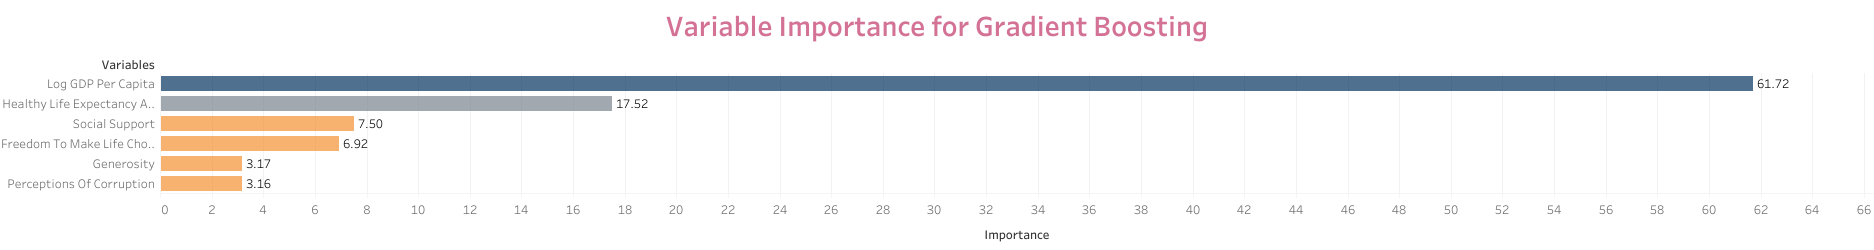

The order of importance is Log GDP Per Capita, Healthy Life Expectancy At Birth, Social Support, Freedom To Make Choices, Generosity, and Perceptions of Corruption. Log GDP Per Capita is the most important variable by far, which was not the case in the Random Forest Model. 

In [26]:
add_predictions('Boost Predictions', boost_reg.predict(X_test))

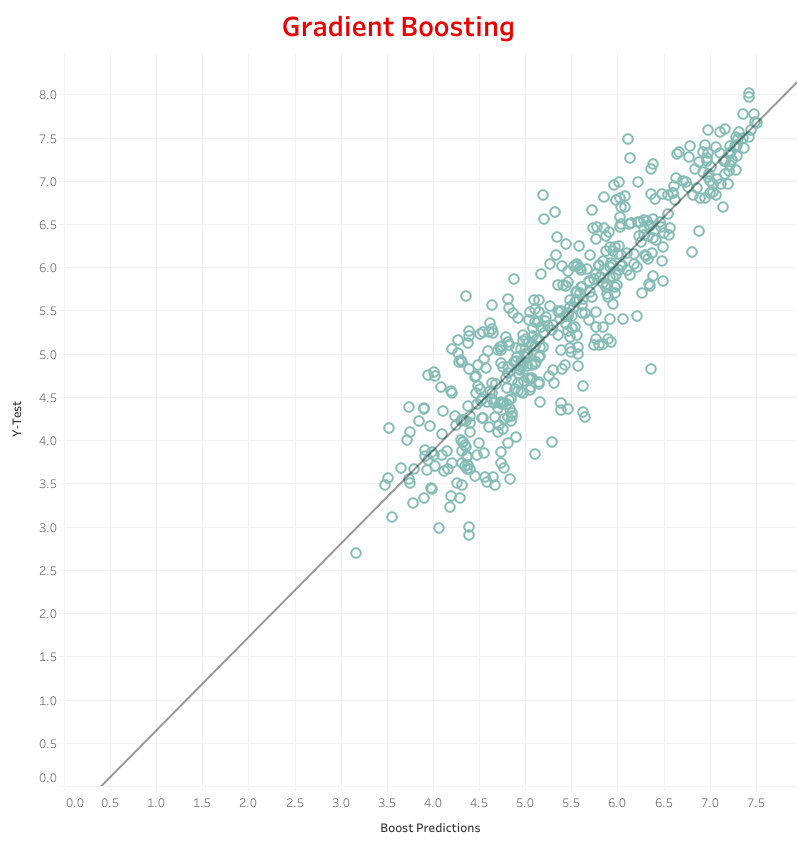

### 2e. Bagging Model

I will test the Bagging Model. 

In [27]:
bag_reg = BaggingRegressor(random_state=1)
bag_params = {'n_estimators':np.linspace(1, 100, 10, dtype=int), 'max_samples': np.linspace(0.1, 1, 10)}
bag_best = GridSearchCV(bag_reg, bag_params, cv=5, scoring = 'neg_mean_squared_error').fit(X_train, y_train)
bag_best.best_estimator_

BaggingRegressor(max_samples=0.9, n_estimators=100, random_state=1)

The best split has .9 max samples and 100 estimators. 

In [28]:
bag_reg = BaggingRegressor(n_estimators = 100, max_samples=0.9, random_state=1).fit(X_train, y_train)

tree_mse(bag_reg)

Training MSE : 0.03410649353952181
Test MSE     : 0.23643746499909055
CV MSE       : 0.2061056657537464


The Bagging Model's Test mean squared error is .236 and its Cross-validation mean squared error is .206.

In [29]:
bag_reg.feature_importances_ = np.mean([tree.feature_importances_ for tree in bag_reg.estimators_], axis=0)
importance_models('Importance (Bagging)', bag_reg)

                                  Importance (RF)  Importance (Boosting)  \
Log Gdp Per Capita                      32.308781              61.720324   
Social Support                          20.007024               7.503354   
Healthy Life Expectancy At Birth        25.101109              17.523646   
Freedom To Make Life Choices            10.631933               6.922314   
Generosity                               4.744188               3.166406   
Perceptions Of Corruption                7.206964               3.163956   

                                  Importance (Bagging)  
Log Gdp Per Capita                           59.028256  
Social Support                                8.860937  
Healthy Life Expectancy At Birth             17.527757  
Freedom To Make Life Choices                  7.203479  
Generosity                                    3.793037  
Perceptions Of Corruption                     3.586534  


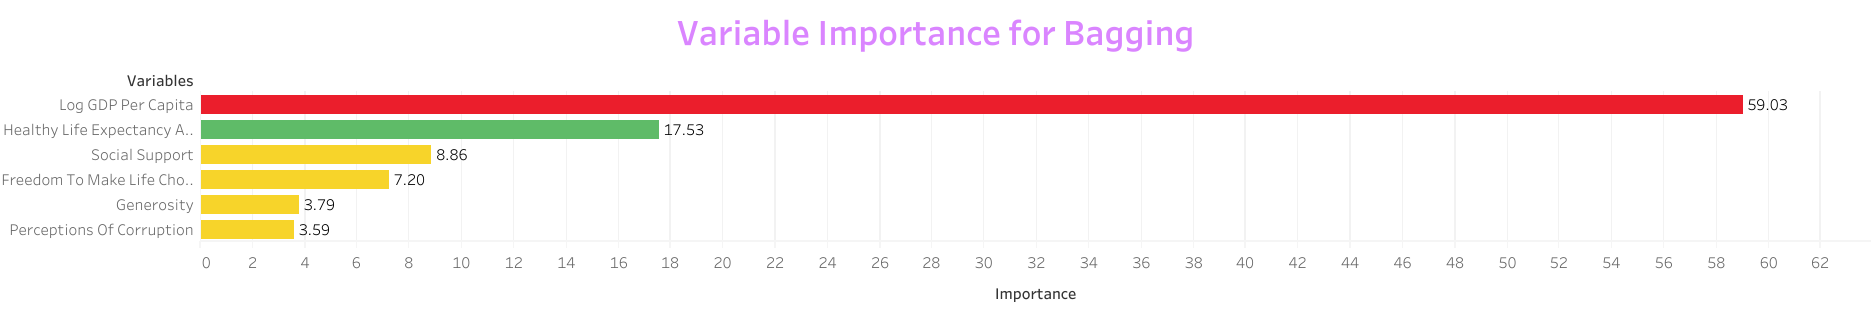

The order of importance is Log GDP Per Capita, Healthy Life Expectancy At Birth, Social Support, Freedom To Make Choices, Generosity, and Perceptions of Corruption. Log GDP Per Capita is the most important variable by far, like the Gradient Boosting Model. 

In [30]:
add_predictions('Bag Predictions', bag_reg.predict(X_test))

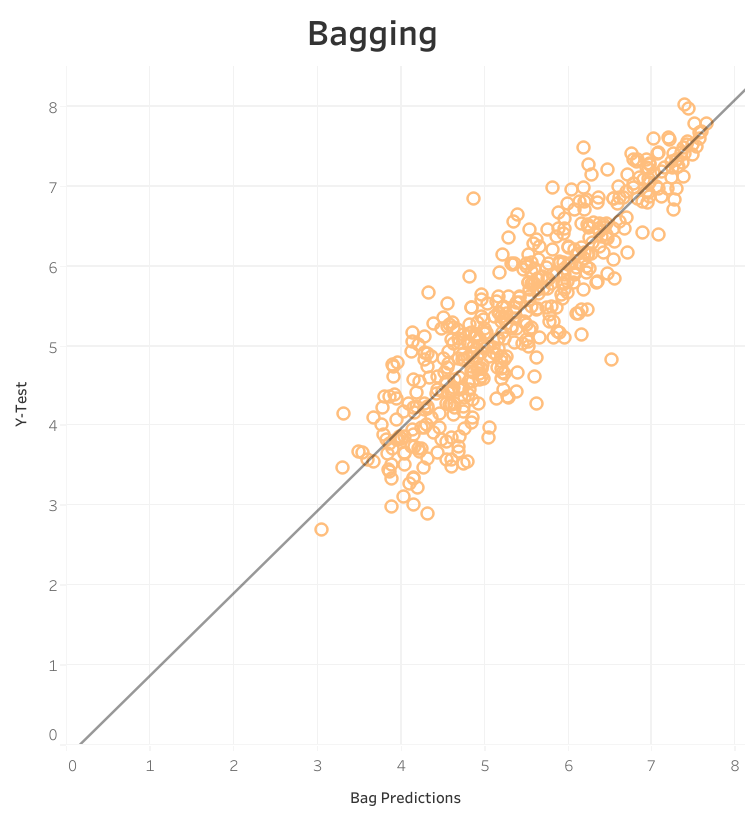

### 2f. Testing Performance Across Models

Now I can compare the mean squared errors across all the models to find the one that predicts Life Ladder the best. 

In [31]:
table = [['Method', 'OLS', 'Decision Tree', 'Random Forest', 'Boosting', 'Bagging'], ['Train Test Split', .391, .317, .229, .239, .236], ['Cross-validation MSE', .344, .310, .198, .223, .206]]
print(tabulate(table, headers = 'firstrow', tablefmt = 'fancy_grid'))

╒══════════════════════╤═══════╤═════════════════╤═════════════════╤════════════╤═══════════╕
│ Method               │   OLS │   Decision Tree │   Random Forest │   Boosting │   Bagging │
╞══════════════════════╪═══════╪═════════════════╪═════════════════╪════════════╪═══════════╡
│ Train Test Split     │ 0.391 │           0.317 │           0.229 │      0.239 │     0.236 │
├──────────────────────┼───────┼─────────────────┼─────────────────┼────────────┼───────────┤
│ Cross-validation MSE │ 0.344 │           0.31  │           0.198 │      0.223 │     0.206 │
╘══════════════════════╧═══════╧═════════════════╧═════════════════╧════════════╧═══════════╛


## 3. Conclusions

As we can see in the Testing Performance Table, the Random Forest Model is the best at predicting happiness with the lowest Testing and Cross-validation Mean Squared Errors of .229 and .198, respectively. 

In [32]:
importance

,Importance (RF),Importance (Boosting),Importance (Bagging)
Log Gdp Per Capita,32.308781,61.720324,59.028256
Social Support,20.007024,7.503354,8.860937
Healthy Life Expectancy At Birth,25.101109,17.523646,17.527757
Freedom To Make Life Choices,10.631933,6.922314,7.203479
Generosity,4.744188,3.166406,3.793037
Perceptions Of Corruption,7.206964,3.163956,3.586534


As seen in the Variable Importance table and each model's bar plots, the most important social and economic factors in predicting happiness are in order: Log GDP Per Capita, Healthy Life Expectancy At Birth, Social Support, Freedom To Make Choices, Generosity, and Perceptions Of Corruption according to the Gradient Boosting and Bagging Models. In the Random Forest Model, the order of importance is the same, except Perceptions Of Corruption are slightly more important than Generosity. 

The Random Forest Model also had a much lower importance value for Log GDP Per Capita than the Gradient Boosting and Bagging Models. Those models had Log GDP Per Capita as being the most important variable by a large margin. Despite those small differences, the models primarily agree on the most important variables. 

Log GDP Per Capita being the most important social and economic factor makes sense because when people are economically secure they are generally happier. Conversely, they are not happy when they are financially struggling because that jeopardizes their ability to keep themselves afloat.   

My analysis had some limitations that I would like to discuss. For example, I substituted the missing predictor values with their respective means. This added some bias to the data because I might have underestimated or overestimated the actual values. A better approach would have been to predict them using Random Forests. Another limitation was ignoring the other happiness metrics of Positive Affect and Negative Affect. Moreover, there are other Machine Learning Algorithms I did not look at that could have been better at predicting happiness than the Random Forest Model, such as Logistic Regression and K-Means Clustering. 

There is more information to find out from this dataset. I did not focus on any specific country or region for my analysis but they would likely vary in which factors are most important in predicting happiness. For instance, I hypothesize in countries ruled by dictators Perceptions of Corruption would be more important in predicting happiness than in my analysis where it was the least significant factor. I also did not look at specific years. In 2020, Social Support could have been more important in predicting happiness due to governments giving people more money. These are topics worth delving into. 